In [58]:

#Setup Python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.preprocessing import normalize


%matplotlib inline

In [61]:
#Load image
img1 = cv2.imread('chapel1.png',0) 
img2 = cv2.imread('chapel2.png',0) 

# Based on Tutorial cited here: 
# http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html

# Strategy: Implement SIFT, Then use Flann based Matcher to decide which points to choose. The implementation uses 
# Lowe's ratio test.
sift = cv2.SIFT()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


In [65]:
pts1 = np.float64(pts1)
pts2 = np.float64(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

F_norm = normalize(F)
# We select only inlier points USING THE 

pts1_inliers = pts1[mask.ravel()==1]
pts2_inliers = pts2[mask.ravel()==1]
pts1_outliers = pts1[mask.ravel()==0]
pts2_liers = pts2[mask.ravel()==0]

In [78]:
print F_norm

[[ -5.92892098e-05   3.17703270e-03  -9.99994951e-01]
 [ -2.12518849e-04   9.55998110e-06  -9.99999977e-01]
 [  1.08707578e-02   2.20421358e-01   9.75344171e-01]]


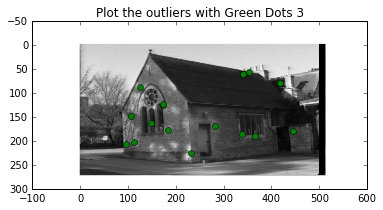

In [77]:
#Plot Outliers on image 1 

fig = plt.figure()

plt.figure(3)
plt.title("Plot the outliers with Green Dots "+ str(3))
plt.imshow(imgs[0],cmap="gray")
for i in range(len(pts1_outliers)):
    plt.plot(pts1_outliers[i][0],pts1_outliers[i][1],'go') 